### Install yfinance package

In [ ]:
pip install yfinance

### Initial basic libraries

In [743]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import numpy as np

### Libraries used for pulling data

In [743]:
import alpaca_trade_api as tradeapi
import csv
import json
from datetime import datetime, timezone

### Libraries used for visualization

In [743]:
pn.extension('plotly')
import plotly.express as px
import hvplot.pandas
import matplotlib.pyplot as plt
import panel as pn
from panel.interact import interact
import plotly.tools
import seaborn as sns

### Libraries used for data analysis

In [743]:
from MCForecastTools import MCSimulation

### New libraries used

In [741]:
# Yahoo finance for data pulling of S&P500 index
import yfinance as yf

# Warning filter that removes warning messages
import warnings
warnings.filterwarnings("ignore")

In [738]:
# Load .env variables
load_dotenv()

True

## Fetching Stock Data

In [218]:
# Set Alpaca API key and secret key
alpaca_key = os.getenv('ALPACA_API_KEY')
alpaca_priv_key = os.getenv('ALPACA_SECRET_KEY')

In [219]:
# Check data types to ensure key imports were successful
print(type(alpaca_key))
print(type(alpaca_priv_key))

<class 'str'>
<class 'str'>


In [220]:
# Create alpaca API object
api = tradeapi.REST(
    alpaca_key,
    alpaca_priv_key,
    api_version = 'v2')

In [221]:
# Create parameters to be used in data pulling
start = pd.Timestamp('2017-05-05', tz='America/New_York').isoformat()
end = pd.Timestamp('2022-05-05', tz='America/New_York').isoformat()
tickers = ['AAPL', 'MSFT', 'AMZN' , 'TSLA', 'GOOGL']
timeframe = '1Day'

In [222]:
# Pull data
stock_pulled_df = api.get_bars(
    tickers,
    timeframe,
    start = start,
    end = end
).df

In [223]:
# Pull S&P500 data
sp500 = yf.Ticker('^GSPC')
sp500 = sp500.history(period='5y', start_date=start, end_date=end)

In [224]:
# Reformat S&P500 dataframe to allign with stock dataframe
# Drop index column name
sp500.index.name = None

# Initialize drop list
sp500_drop_list = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits']

# Rename close column
sp500 = sp500.drop(sp500_drop_list, axis=1).rename(columns = {'Close' : 'close'})

# Save S&P500 data to csv
sp500.to_csv('Data_files/S&P500.csv')

In [225]:
# Create a list of columns needed to be removed
drop_list = ['open', 'vwap', 'high', 'low', 'volume', 'trade_count', 'symbol']

# Slice dataframe and drop columns
aapl = stock_pulled_df[stock_pulled_df['symbol']=='AAPL'].drop(drop_list, axis=1)
msft = stock_pulled_df[stock_pulled_df['symbol']=='MSFT'].drop(drop_list, axis=1)
amzn = stock_pulled_df[stock_pulled_df['symbol']=='AMZN'].drop(drop_list, axis=1)
tsla = stock_pulled_df[stock_pulled_df['symbol']=='TSLA'].drop(drop_list, axis=1)
googl = stock_pulled_df[stock_pulled_df['symbol']=='GOOGL'].drop(drop_list, axis=1)

# Concatenate sliced data into new dataframe
stock_df = pd.concat(
    [aapl, msft, amzn, tsla, googl],
    axis=1,
    keys=['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOGL']
)

# Index dataframe by date
stock_df.index=stock_df.index.date

# Drop any Null values
stock_df.dropna()

AAPL    MSFT     AMZN    TSLA    GOOGL
             close   close    close   close    close
2017-05-05  148.96   69.00   934.15  308.35   950.28
2017-05-08  153.01   68.94   949.04  307.19   958.69
2017-05-09  153.99   69.04   952.82  321.26   956.71
2017-05-10  153.26   69.31   948.95  325.22   954.84
2017-05-11  153.95   68.46   947.62  323.10   955.89
...            ...     ...      ...     ...      ...
2022-04-29  157.65  277.52  2485.63  870.76  2282.19
2022-05-02  157.96  284.47  2490.00  902.94  2331.66
2022-05-03  159.48  281.78  2485.07  909.25  2346.68
2022-05-04  166.02  289.98  2518.57  952.62  2445.22
2022-05-05  156.77  277.35  2328.14  873.28  2330.11

[1260 rows x 5 columns]

## Fetching Crypto Data

In [226]:
# Defining URLs
btc_url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from=1493906401&to=1651759199'
eth_url = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range?vs_currency=usd&from=1493906401&to=1651759199'
ltc_url = 'https://api.coingecko.com/api/v3/coins/litecoin/market_chart/range?vs_currency=usd&from=1493906401&to=1651759199'
xrp_url = 'https://api.coingecko.com/api/v3/coins/ripple/market_chart/range?vs_currency=usd&from=1493906401&to=1651759199'
ada_url = 'https://api.coingecko.com/api/v3/coins/cardano/market_chart/range?vs_currency=usd&from=1493906401&to=1651759199'

In [227]:
# Perform GET request to pull data for cryptos
btc_request = requests.get(btc_url)
eth_request = requests.get(eth_url)
ltc_request = requests.get(ltc_url)
xrp_request = requests.get(xrp_url)
ada_request = requests.get(ada_url)

In [228]:
# Convert pulled data into json
btc_request = btc_request.json()
eth_request = eth_request.json()
ltc_request = ltc_request.json()
xrp_request = xrp_request.json()
ada_request = ada_request.json()

In [229]:
# Create and organize dataframes for cryptos
btc_df = pd.DataFrame(btc_request['prices'])
eth_df = pd.DataFrame(eth_request['prices'])
ltc_df = pd.DataFrame(ltc_request['prices'])
xrp_df = pd.DataFrame(xrp_request['prices'])
ada_df = pd.DataFrame(ada_request['prices'])

In [230]:
# Rename columns
btc_df.rename(columns = {0 : 'Date', 1 : 'close'}, inplace=True)
eth_df.rename(columns = {0 : 'Date', 1 : 'close'}, inplace=True)
ltc_df.rename(columns = {0 : 'Date', 1 : 'close'}, inplace=True)
xrp_df.rename(columns = {0 : 'Date', 1 : 'close'}, inplace=True)
ada_df.rename(columns = {0 : 'Date', 1 : 'close'}, inplace=True)

In [231]:
# Convert unix time format into traditonal date format
btc_df['date'] = pd.to_datetime(btc_df['Date'], unit='ms')
eth_df['date'] = pd.to_datetime(eth_df['Date'], unit='ms')
ltc_df['date'] = pd.to_datetime(ltc_df['Date'], unit='ms')
xrp_df['date'] = pd.to_datetime(xrp_df['Date'], unit='ms')
ada_df['date'] = pd.to_datetime(ada_df['Date'], unit='ms')

In [232]:
# Set new date format as index
btc_df.set_index('date', inplace=True)
eth_df.set_index('date', inplace=True)
ltc_df.set_index('date', inplace=True)
xrp_df.set_index('date', inplace=True)
ada_df.set_index('date', inplace=True)

In [233]:
# Drop unix column
btc_df.drop(['Date'], axis=1, inplace=True)
eth_df.drop(['Date'], axis=1, inplace=True)
ltc_df.drop(['Date'], axis=1, inplace=True)
xrp_df.drop(['Date'], axis=1, inplace=True)
ada_df.drop(['Date'], axis=1, inplace=True)

In [234]:
## Concatenate crypto dataframes
# Create a list of cypto tickers
crypto_tickers = crypto_df.droplevel(axis=1, level=[-1]).keys().tolist()

crypto_df = pd.concat(
    [btc_df, eth_df, ltc_df, xrp_df, ada_df],
    axis=1,
    keys=['BTC', 'ETH', 'LTC',  'XRP', 'ADA']
)

In [235]:
# Concatenate crypto and stock data
combined_investments = pd.concat(
    [crypto_df, stock_df],
    axis=1,
    keys=['Crypto Data', 'Stock Data']
)

# Save data to csv
combined_investments.to_csv('Data_files/combined_investments.csv')

## Profit after 5 years

In [236]:
# Initialize Dataframe structure
investment_data = {'Investment' : [None],
                  'Profit After 5 Years' : [None]}

# Initialize Dataframe
value_after_5_years = pd.DataFrame(investment_data).drop(0)

In [237]:
# Define Function that calculates profit then appends investment into a dataframe
def value_today_after_5_years(data, data2, investment_type, investment):
    investment_type=investment_type
    investment=investment
    data=(combined_investments[investment_type][investment].fillna(method='bfill', axis=0).iloc[0]).values[0]
    data2=(combined_investments[investment_type][investment].fillna(method='bfill', axis=0).iloc[-1]).values[0]
    profit=(4000/data) * data2 - 4000
    df_variable=pd.DataFrame({'Investment' : [investment],
                              'Profit After 5 Years' : [profit]})
    return value_after_5_years.append(df_variable, ignore_index=True)

In [238]:
# Run function for each investment
value_after_5_years = value_today_after_5_years(
    investment_type='Stock Data',
    investment='AAPL',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Stock Data',
    investment='MSFT',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Stock Data',
    investment='AMZN',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Stock Data',
    investment='TSLA',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Stock Data',
    investment='GOOGL',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Crypto Data',
    investment='BTC',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Crypto Data',
    investment='ETH',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Crypto Data',
    investment='LTC',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Crypto Data',
    investment='XRP',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Crypto Data',
    investment='ADA',
    data=combined_investments,
    data2=combined_investments  
)

In [239]:
# Change index to investments
value_after_5_years = value_after_5_years.set_index('Investment')

In [768]:
# Plot the profits after 5 years in bar graph
combined_value_after_5_years_bar = value_after_5_years.hvplot.bar(
    title='Profit of Each Investment After 5 Years',
    ylabel='Profit in USD',
    xlabel='Investment',
    color='green',
    yformatter='%.0f'
).opts(axiswise=True)

combined_value_after_5_years_bar

:Bars   [Investment]   (Profit After 5 Years)

In [769]:
# Plot the profits after 5 years in line graph
combined_value_after_5_years_line = value_after_5_years.hvplot.line(
    title='Profit of Each Investment After 5 Years',
    ylabel='Profit in USD',
    xlabel='Investment',
    color='green',
    yformatter='%.0f',
).opts(axiswise=True)

combined_value_after_5_years_line

:Curve   [Investment]   (Profit After 5 Years)

In [764]:
# Plot the profits of stocks after 5 years in bar graph
stock_value_after_5_years = value_after_5_years.drop(crypto_tickers)

stock_value_after_5_years_bar = stock_value_after_5_years.hvplot.bar(
    title='Profits of Stocks After 5 Years',
    ylabel='Profit Made After 5 Years (USD)',
    color='green',
    yformatter='%.0f'
).opts(axiswise=True)

stock_value_after_5_years_bar

:Bars   [Investment]   (Profit After 5 Years)

In [765]:
# Plot the profits of crypto after 5 years in bar graph
crypto_value_after_5_years_bar = value_after_5_years.iloc[5:10].hvplot.bar(
    yformatter='%.0f',
    title='Profits of Crypto After 5 Years',
    ylabel='Profit Made After 5 Years (USD)'
).opts(axiswise=True)

crypto_value_after_5_years_bar

:Bars   [Investment]   (Profit After 5 Years)

In [489]:
prices_start = (combined_investments.fillna(method='bfill', axis=0).iloc[0])
prices_latest = (combined_investments.fillna(method='bfill', axis=0).iloc[-1])

## Calculate daily and cumulative returns

In [242]:
# Calculate daily returns for stock
stock_daily_returns = stock_df.pct_change()

# Rename columns
stock_daily_returns.rename(columns = {'close' : 'Daily Return %'}, inplace=True)

In [438]:
# Calculate daily returns for stock
crypto_daily_returns = crypto_df.pct_change()

# Rename columns
crypto_daily_returns.rename(columns = {'close' : 'Daily Return %'}, inplace=True)

In [439]:
# Create merged dataframe for stock and crypto
daily_returns = pd.merge(
    crypto_daily_returns, 
    stock_daily_returns,
    left_index=True, 
    right_index=True)

# Save csv file
daily_returns.to_csv('Data_files/daily_returns.csv')

In [245]:
# Calculate cumulative daily returns
cumulative_returns = (1 + daily_returns).cumprod()
cumulative_returns.to_csv('Data_files/cumulative_returns.csv')

## Invesment Planning

In [618]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns, stocks
mc_even_dist = MCSimulation(
    portfolio_data = stock_df, 
    weights = [0.2, 0.2, 0.2, 0.2, 0.2], 
    num_simulation = 500, 
    num_trading_days = 252*5
)

In [619]:
# Printing the simulation input data
mc_even_dist.portfolio_data.head()

AAPL                MSFT                 AMZN               \
             close daily_return  close daily_return   close daily_return   
2017-05-05  148.96          NaN  69.00          NaN  934.15          NaN   
2017-05-08  153.01     0.027189  68.94    -0.000870  949.04     0.015940   
2017-05-09  153.99     0.006405  69.04     0.001451  952.82     0.003983   
2017-05-10  153.26    -0.004741  69.31     0.003911  948.95    -0.004062   
2017-05-11  153.95     0.004502  68.46    -0.012264  947.62    -0.001402   

              TSLA                GOOGL               
             close daily_return   close daily_return  
2017-05-05  308.35          NaN  950.28          NaN  
2017-05-08  307.19    -0.003762  958.69     0.008850  
2017-05-09  321.26     0.045802  956.71    -0.002065  
2017-05-10  325.22     0.012326  954.84    -0.001955  
2017-05-11  323.10    -0.006519  955.89     0.001100

In [620]:
# Run Monte-Carlo Simulation
mc_even_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.999021  0.989062  0.997396  0.989728  1.015232  0.994941  1.002599   
2     1.010582  0.986146  1.000538  0.990828  1.016201  0.994245  1.001346   
3     1.009140  0.987970  1.018541  1.001935  1.014681  0.988613  0.993098   
4     1.018750  0.979820  1.010136  1.018860  1.005195  0.987027  1.007350   
...        ...       ...       ...       ...       ...       ...       ...   
1256  5.007285  4.673308  5.966384  1.691104  5.019057  3.575554  2.152768   
1257  5.043717  4.679829  5.850584  1.689428  5.088563  3.612785  2.103470   
1258  5.126701  4.654070  5.801620  1.695146  5.112021  3.607166  2.100616   
1259  5.083395  4.668320  5.792834  1.694626  5.120529  3.545343  2.099022   
1260  5.131844  4.612329  5.720849  1.695673  5.011833  3.599696  2.110250   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.022630  1.011019  1.008337  ...  1.014033  1.014110  1.014689   
2     1.019023  1.018186  1.018721  ...  1.018541  1.022706  1.017197   
3     1.022743  1.038396  1.015580  ...  1.014999  1.036001  1.035779   
4     1.022092  1.057264  1.005436  ...  1.030124  1.020468  1.037641   
...        ...       ...       ...  ...       ...       ...       ...   
1256  2.952252  2.123051  3.140263  ...  4.352921  4.616764  4.076300   
1257  2.913671  2.114919  3.157064  ...  4.252115  4.622909  4.156484   
1258  2.912708  2.127897  3.084846  ...  4.340286  4.546146  4.104034   
1259  2.922957  2.079836  3.073509  ...  4.318470  4.582908  4.044065   
1260  2.869704  2.102855  3.083136  ...  4.374736  4.554793  4.129492   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.009975  1.018862  1.018171  0.991574  1.005474  0.988085  1.013374  
2     1.019933  1.027908  0.996045  0.992257  1.013241  0.964802  1.010748  
3     1.020132  1.030526  0.993820  1.004243  1.011237  0.965908  0.989160  
4     1.039114  1.051530  0.998034  0.996480  1.024796  0.991379  0.996636  
...        ...       ...       ...       ...       ...       ...       ...  
1256  5.305645  3.482965  7.073708  5.110162  2.796659  6.104008  4.447232  
1257  5.195051  3.521579  7.089419  5.081333  2.799290  6.155228  4.493005  
1258  5.108940  3.582971  7.267617  4.988952  2.826685  6.107135  4.504483  
1259  5.049681  3.593856  7.249340  5.008831  2.853260  6.065442  4.519911  
1260  5.031649  3.597519  7.185594  4.950993  2.859109  6.247760  4.495480  

[1261 rows x 500 columns]

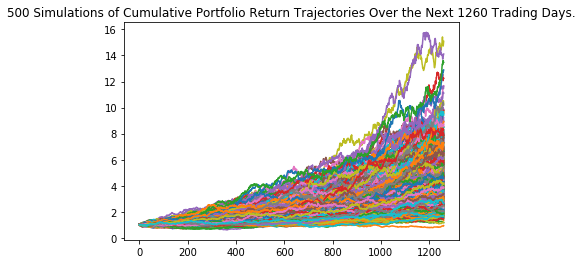

In [848]:
# Plot simulation outcomes
mc_even_distline_plot = mc_even_dist.plot_simulation()

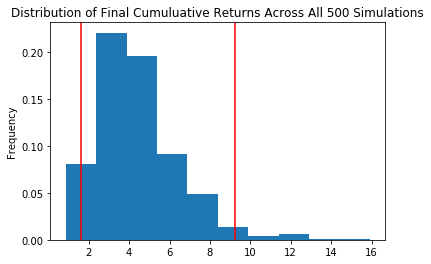

In [623]:
# Plot probability distribution and confidence intervals
mc_dist_plot = mc_even_dist.plot_distribution()

In [822]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
mc_even_dist_2 = MCSimulation(
    portfolio_data = crypto_df, 
    weights = [0.2, 0.2, 0.2, 0.2, 0.2], 
    num_simulation = 500, 
    num_trading_days = 252*5
)

In [823]:
# Printing the simulation input data
mc_even_dist_2.portfolio_data.head()

BTC                     ETH                     LTC  \
                close daily_return      close daily_return      close   
2017-05-05  1506.0438          NaN  91.160387          NaN  26.199396   
2017-05-06  1547.8150     0.027736  96.427680     0.057780  28.175799   
2017-05-07  1557.8838     0.006505  89.739679    -0.069358  30.199878   
2017-05-08  1633.3800     0.048461  87.948120    -0.019964  28.656030   
2017-05-09  1700.1775     0.040895  87.502444    -0.005067  30.062591   

                              XRP                ADA               
           daily_return     close daily_return close daily_return  
2017-05-05          NaN  0.092864          NaN   NaN          NaN  
2017-05-06     0.075437  0.102521     0.103991   NaN          NaN  
2017-05-07     0.071838  0.137873     0.344827   NaN          NaN  
2017-05-08    -0.051121  0.201431     0.460989   NaN          NaN  
2017-05-09     0.049084  0.160441    -0.203494   NaN          NaN

In [824]:
# Run Monte-Carlo Simulation
mc_even_dist_2.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1          2           3          4          5    \
0      1.000000  1.000000   1.000000    1.000000   1.000000   1.000000   
1      1.012672  0.979699   0.976488    1.026078   1.019323   1.050270   
2      1.014856  0.956614   0.974500    1.001566   1.004604   1.021414   
3      1.044145  0.899302   0.987355    1.021353   1.019971   1.084249   
4      0.995072  0.850441   1.012389    1.027778   1.068021   1.069757   
...         ...       ...        ...         ...        ...        ...   
1256  73.452979  5.603770  28.511266  114.471457  33.646073  89.832424   
1257  73.061921  5.597657  28.312979  110.780142  32.974423  87.901851   
1258  74.274899  5.474577  28.793711  118.514058  33.028142  88.750522   
1259  74.414253  5.650068  30.063803  113.972116  33.880733  91.222801   
1260  75.701594  5.364464  30.661347  113.764848  34.855910  95.698874   

           6          7         8          9    ...        490        491  \
0     1.000000   1.000000  1.000000   1.000000  ...   1.000000   1.000000   
1     0.982427   0.999071  0.992234   0.970485  ...   0.992371   1.049708   
2     0.997385   1.015229  0.961232   0.944526  ...   0.955844   1.068394   
3     0.987197   1.005586  0.983950   0.962791  ...   0.957760   1.140203   
4     1.021784   0.983388  0.988696   0.964891  ...   0.944480   1.136169   
...        ...        ...       ...        ...  ...        ...        ...   
1256  1.885349  79.587471  6.537571  36.726059  ...  67.461703  10.634974   
1257  1.802727  78.017143  6.623676  37.622576  ...  66.973946  10.326499   
1258  1.771139  83.079312  6.797045  39.439984  ...  66.080998  10.119480   
1259  1.675708  77.230504  7.316572  39.801692  ...  68.014094  10.112311   
1260  1.714740  78.020177  7.041045  39.113293  ...  70.498320   9.729712   

             492         493       494        495        496        497  \
0       1.000000    1.000000  1.000000   1.000000   1.000000   1.000000   
1       0.988683    1.026716  1.020286   1.021600   1.020977   1.035153   
2       0.989282    1.013539  1.017646   1.037080   1.029808   1.085812   
3       1.004662    0.991331  0.976947   1.095061   1.013982   1.074708   
4       0.992809    0.945359  0.979021   1.043505   0.984670   1.093967   
...          ...         ...       ...        ...        ...        ...   
1256  102.199248  191.472130  5.797668  80.643823  25.507866  15.578804   
1257  102.417713  198.867756  5.747089  80.295519  25.303067  15.348497   
1258  101.214974  201.716649  5.586488  82.540749  25.649969  15.326909   
1259   93.853654  206.042643  5.298220  79.107539  26.054645  14.962713   
1260   93.936673  209.792141  5.625270  78.974429  25.788853  14.668466   

            498        499  
0      1.000000   1.000000  
1      1.027636   1.029376  
2      1.059575   1.037356  
3      1.018573   1.020077  
4      1.001923   0.994616  
...         ...        ...  
1256  68.865271  33.731138  
1257  68.194979  34.690624  
1258  69.834793  34.483244  
1259  68.982656  34.094034  
1260  71.353902  34.519664  

[1261 rows x 500 columns]

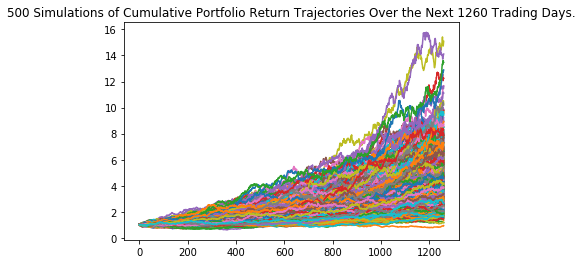

In [825]:
# Plot simulation outcomes
mc_even_dist_2 = mc_even_dist.plot_simulation()

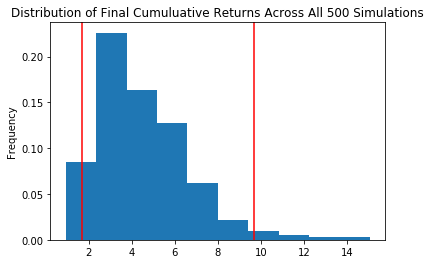

In [826]:
# Plot probability distribution and confidence intervals
mc_even_dist_2 = mc_even_dist.plot_distribution()

## Retirement Analysis

In [625]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl = mc_even_dist.summarize_cumulative_return()

# Print summary statistics
print(even_tbl)

count           500.000000
mean              4.426339
std               2.075076
min               0.855517
25%               2.949244
50%               4.117337
75%               5.384357
max              15.927135
95% CI Lower      1.593780
95% CI Upper      9.243655
Name: 1260, dtype: float64


## Risk Analysis
Determine the risk of each portfolio:

1. Create a box plot for each portfolio.
2. Calculate the standard deviation for all portfolios.
3. Calculate the Annualized Standard Deviation.

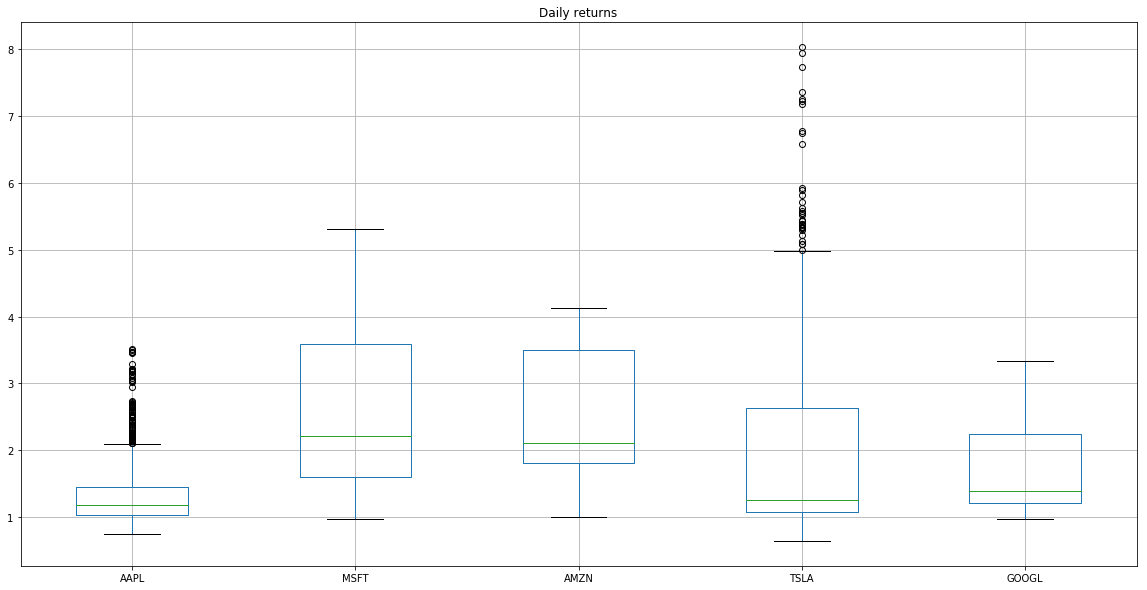

In [696]:
stock_boxplot = cumulative_returns[tickers].droplevel(axis=1, level=[-1]).boxplot(figsize=(20,10)).set_title("Daily returns")

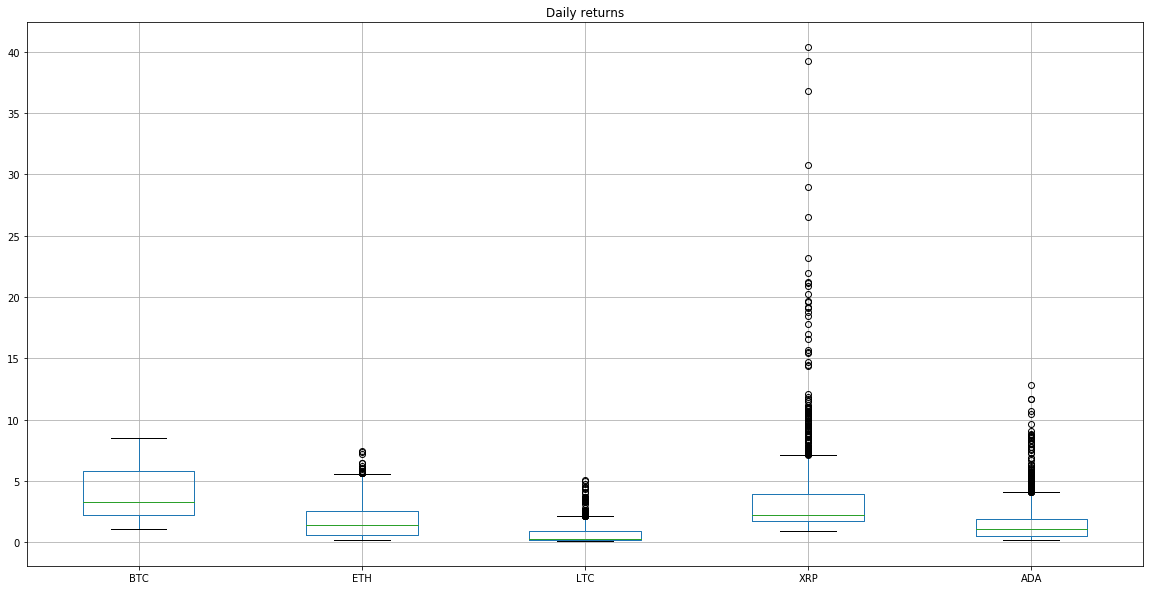

In [627]:
crypto_boxplot = cumulative_returns[crypto_tickers].droplevel(axis=1, level=[-1]).boxplot(figsize=(20,10)).set_title("Daily returns")

## Calculate Standard Deviations

In [572]:
# Calculate the daily standard deviations of all portfolios
combined_daily_std = cumulative_returns.droplevel(axis=1, level=[-1]).std()

""" Daily Standard Deviation in decending order"""

combined_daily_std.sort_values(ascending=False)

XRP      3.665658
BTC      1.981721
ADA      1.661982
ETH      1.280264
MSFT     1.245492
TSLA     1.181228
AMZN     0.942335
LTC      0.741431
GOOGL    0.712097
AAPL     0.477175
dtype: float64

#### <font color='Red'> The Standard daviation above shows that XRP had the maximum and Apple stock had the least standard deviation over last 5 years.
</font>

In [573]:
# Calculate the annualized standard deviation (252 trading days)
annualized_std = combined_daily_std * np.sqrt(252)
annualized_std

BTC      31.458847
ETH      20.323558
LTC      11.769853
XRP      58.190520
ADA      26.383148
AAPL      7.574916
MSFT     19.771569
AMZN     14.959105
TSLA     18.751416
GOOGL    11.304184
dtype: float64

#### <font color='Red'> The Annualised Standard daviation however, shows that BTC had the maximum and Google had the least standard deviation over last 5 years.
</font>

## Rolling Statistics
Risk changes over time. Analyze the rolling statistics for Risk and Beta.

1. Calculate and plot the rolling standard deviation for all portfolios using a 21-day window.
2. Calculate the correlation between each items in the stock and crypto portfolio

## Calculate and plot rolling std for all portfolios with 30-day window

In [581]:
# Calculate the rolling standard deviation for all portfolios using a 30-day window
cumulative_returns.droplevel(axis=1, level=[-1]).rolling(window=30).std()

BTC       ETH       LTC       XRP       ADA      AAPL  \
2017-05-05       NaN       NaN       NaN       NaN       NaN       NaN   
2017-05-08       NaN       NaN       NaN       NaN       NaN       NaN   
2017-05-09       NaN       NaN       NaN       NaN       NaN       NaN   
2017-05-10       NaN       NaN       NaN       NaN       NaN       NaN   
2017-05-11       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-04-29  0.333667  0.182205  0.011921  0.150336  0.117009  0.043236   
2022-05-02  0.333764  0.182396  0.012066  0.155145  0.115862  0.044963   
2022-05-03  0.331714  0.180694  0.012165  0.159078  0.113775  0.046242   
2022-05-04  0.330924  0.180972  0.012293  0.161440  0.114024  0.046324   
2022-05-05  0.331338  0.180872  0.012175  0.159793  0.113886  0.048433   

                MSFT      AMZN      TSLA     GOOGL  
2017-05-05       NaN       NaN       NaN       NaN  
2017-05-08       NaN       NaN       NaN       NaN  
2017-05-09       NaN       NaN       NaN       NaN  
2017-05-10       NaN       NaN       NaN       NaN  
2017-05-11       NaN       NaN       NaN       NaN  
...              ...       ...       ...       ...  
2022-04-29  0.208703  0.233588  0.261854  0.199685  
2022-05-02  0.209835  0.264266  0.262272  0.208356  
2022-05-03  0.212026  0.289417  0.264074  0.214872  
2022-05-04  0.209904  0.305478  0.266199  0.213985  
2022-05-05  0.213481  0.333633  0.279504  0.218071  

[1258 rows x 10 columns]

In [773]:
# Plot the rolling standard deviation
rolling_window_plot = cumulative_returns.droplevel(axis=1, level=[-1]).rolling(window=30).std().hvplot.line(title='Return after 5 years With 30 Days as Weighted Average',
                                                                                                        ylabel='Return x',
                                                                                                        xlabel='Year',
                                                                                                        width=1500,
                                                                                                        height=800).opts(axiswise=True)

rolling_window_plot

:NdOverlay   [Variable]
   :Curve   [index]   (value)

#### <font color='Red'> The rolling standard deviation indicator above shows the volatility, charted for 30 days.
</font>

## Calculate and plot the correlation


In [585]:
# Calculate the correlation
correlation_df = daily_returns.droplevel(axis=1, level=[-1]).corr()
correlation_df

BTC       ETH       LTC       XRP       ADA      AAPL      MSFT  \
BTC    1.000000  0.728045  0.734533  0.475947  0.530561 -0.049026 -0.056071   
ETH    0.728045  1.000000  0.764093  0.540141  0.594198 -0.068642 -0.051059   
LTC    0.734533  0.764093  1.000000  0.539073  0.571843 -0.064046 -0.044745   
XRP    0.475947  0.540141  0.539073  1.000000  0.594079 -0.014591 -0.010973   
ADA    0.530561  0.594198  0.571843  0.594079  1.000000 -0.026982 -0.029873   
AAPL  -0.049026 -0.068642 -0.064046 -0.014591 -0.026982  1.000000  0.532587   
MSFT  -0.056071 -0.051059 -0.044745 -0.010973 -0.029873  0.532587  1.000000   
AMZN  -0.008635 -0.009658 -0.001953  0.018899  0.006608  0.418943  0.701903   
TSLA   0.009896  0.006113 -0.010235  0.005906  0.021591  0.613540  0.397233   
GOOGL -0.003715  0.002702 -0.007295  0.025607  0.001236  0.471259  0.787539   

           AMZN      TSLA     GOOGL  
BTC   -0.008635  0.009896 -0.003715  
ETH   -0.009658  0.006113  0.002702  
LTC   -0.001953 -0.010235 -0.007295  
XRP    0.018899  0.005906  0.025607  
ADA    0.006608  0.021591  0.001236  
AAPL   0.418943  0.613540  0.471259  
MSFT   0.701903  0.397233  0.787539  
AMZN   1.000000  0.326082  0.659141  
TSLA   0.326082  1.000000  0.336368  
GOOGL  0.659141  0.336368  1.000000

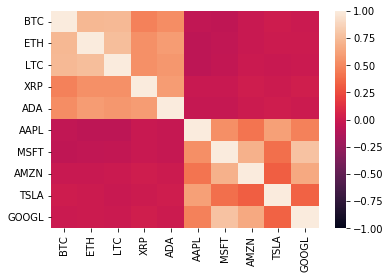

In [629]:
# Display de correlation matrix
corr_heatmap = sns.heatmap(correlation_df, vmin=-1, vmax=1)

#### <font color='Red'> The value of correlation above ranges from -1 to +1. Which clearly indicates stocks ranged in the negative territory to cryptos over last 5 years
</font>

## Sharpe Ratios
For investment perspective, daily returns might not give you a better understanding, let's at the ratio of return-to-risk, and not just returns alone.

### Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [608]:
sharpe_ratios = ((daily_returns.mean()-0.25) * 252) / (daily_returns.std() * np.sqrt(252))
sharpe_ratios = sharpe_ratios.droplevel(axis=0, level=[-1])
sharpe_ratios

BTC      -88.608010
ETH      -70.270541
LTC      -64.358823
XRP      -51.969314
ADA      -49.430136
AAPL    -137.357810
MSFT    -217.506110
AMZN    -194.346793
TSLA     -87.747558
GOOGL   -220.085157
dtype: float64

In [723]:
annulaised_sharpe_ratios = ((combined_daily_std.mean()-0.25) * 252) / (combined_daily_std.std() * np.sqrt(252))
annulaised_sharpe_ratios

19.683976746995047

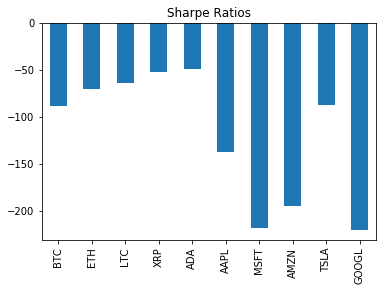

In [630]:
# Visualize the sharpe ratios as a bar plot
sharpe_ratios = sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

## Evaluate Investment Scenarios

### Scenario 1: Evaluate Investment in Original/Unoptimized Portfolio (No Modifications)

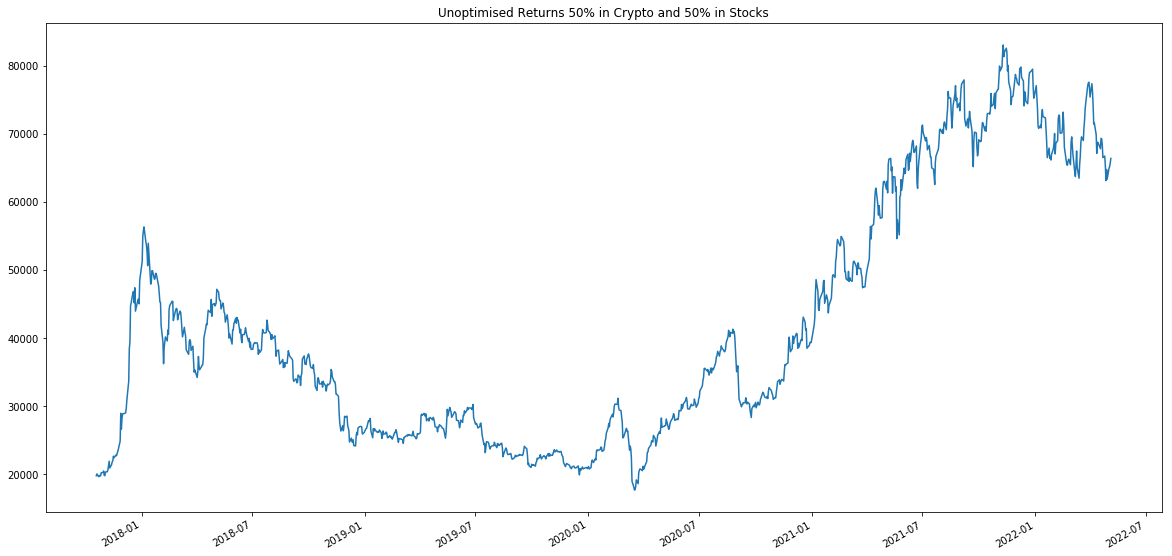

In [837]:
# Set initial investment
initial_investment = 20000

# Set weights
weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Use the `dot` function to multiply weights by each stock's daily returns to output the unoptimized portfolio's daily returns
unoptimized_portfolio_returns = daily_returns.dot(weights)

# Use the `cumprod` function to calculate the unoptimized stock portfolio's cumulative returns
unoptimized_cumulative_returns = (1 + unoptimized_portfolio_returns).cumprod()

# Multiply the initial investment of `$20,000` against the portfolio's series of cumulative returns
unoptimized_cumulative_profits = (initial_investment * unoptimized_cumulative_returns)

# Plot the cumulatives return
unoptimized_cumulative_profits.plot(figsize=(20,10),
                                   title='Unoptimised Returns 50% in Crypto and 50% in Stocks')

### Scenario 2: Evaluate Investment in Crypto optimized Portfolio (No stocks)

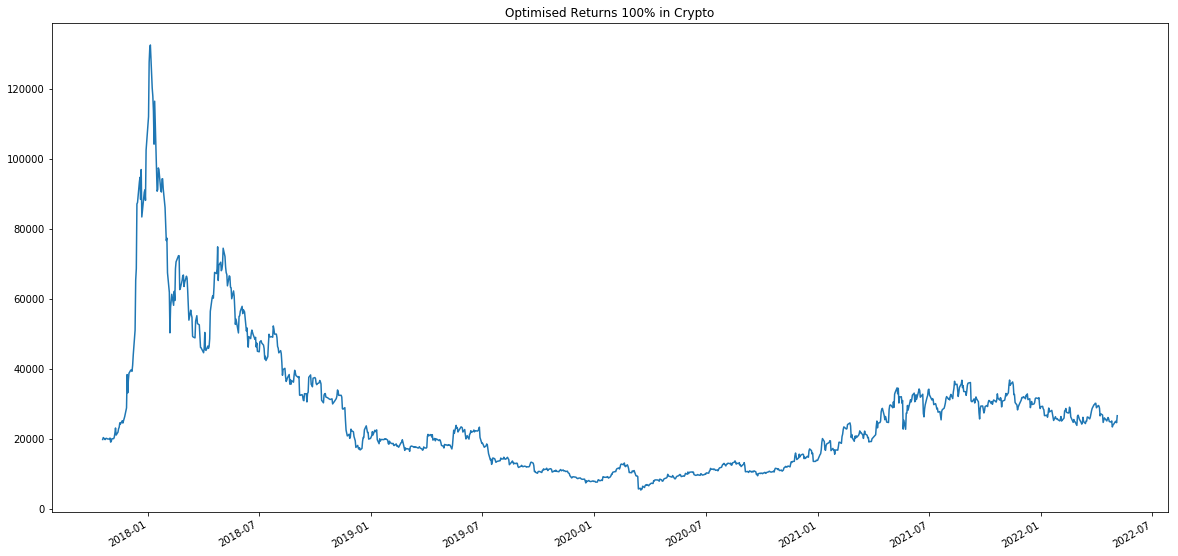

In [839]:
# Set initial investment
initial_investment = 20000

# Set weights
weights = [0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0] 

# Use the `dot` function to multiply weights by each stock's daily returns to output the unoptimized portfolio's daily returns
crypto_optimized_portfolio_returns = daily_returns.dot(weights)

# Use the `cumprod` function to calculate the unoptimized stock portfolio's cumulative returns
crypto_optimized_portfolio_returns = (1 + crypto_optimized_portfolio_returns).cumprod()

# Multiply the initial investment of `$20,000` against the portfolio's series of cumulative returns
crypto_optimized_portfolio_profits = (initial_investment * crypto_optimized_portfolio_returns)

# Plot the cumulatives return
crypto_optimized_portfolio_profits.plot(figsize=(20,10),
                                       title='Optimised Returns 100% in Crypto')

### Scenario 3: Evaluate Investment in Stock optimized Portfolio (No crypto)

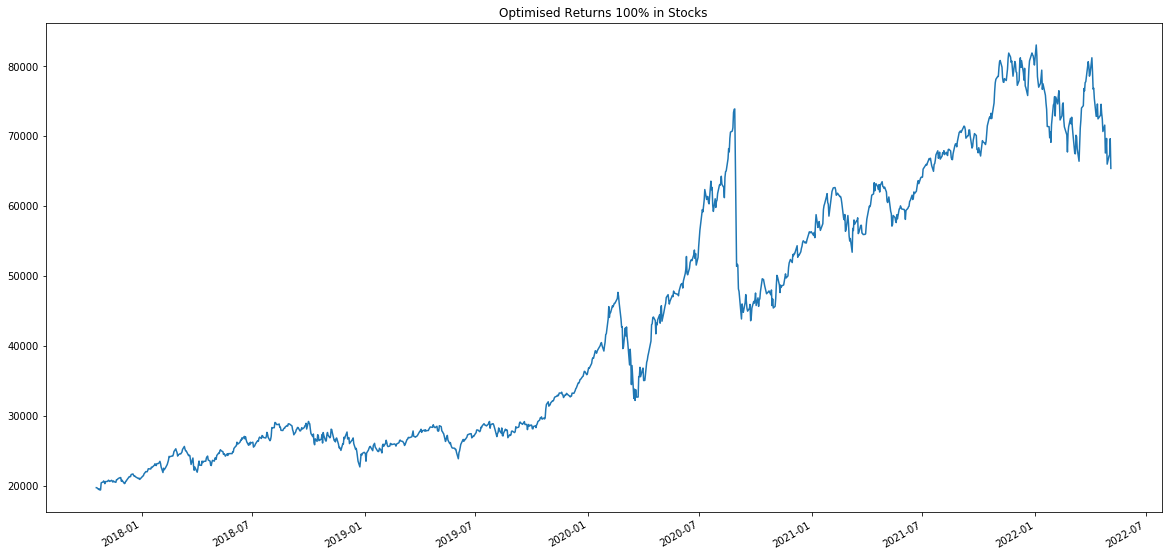

In [840]:
# Set initial investment
initial_investment = 20000

# Set weights
weights = [0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2]

# Use the `dot` function to multiply weights by each stock's daily returns to output the unoptimized portfolio's daily returns
stock_optimized_portfolio_returns = daily_returns.dot(weights)

# Use the `cumprod` function to calculate the unoptimized stock portfolio's cumulative returns
stock_optimized_portfolio_returns = (1 + stock_optimized_portfolio_returns).cumprod()

# Multiply the initial investment of `$20,000` against the portfolio's series of cumulative returns
stock_optimized_portfolio_profits = (initial_investment * stock_optimized_portfolio_returns)

# Plot the cumulatives return
stock_optimized_portfolio_profits.plot(figsize=(20,10),
                                      title='Optimised Returns 100% in Stocks')

### Scenario 4: Evaluate Investment in optimized Portfolio (40% in Crpto and 60% in Stocks)

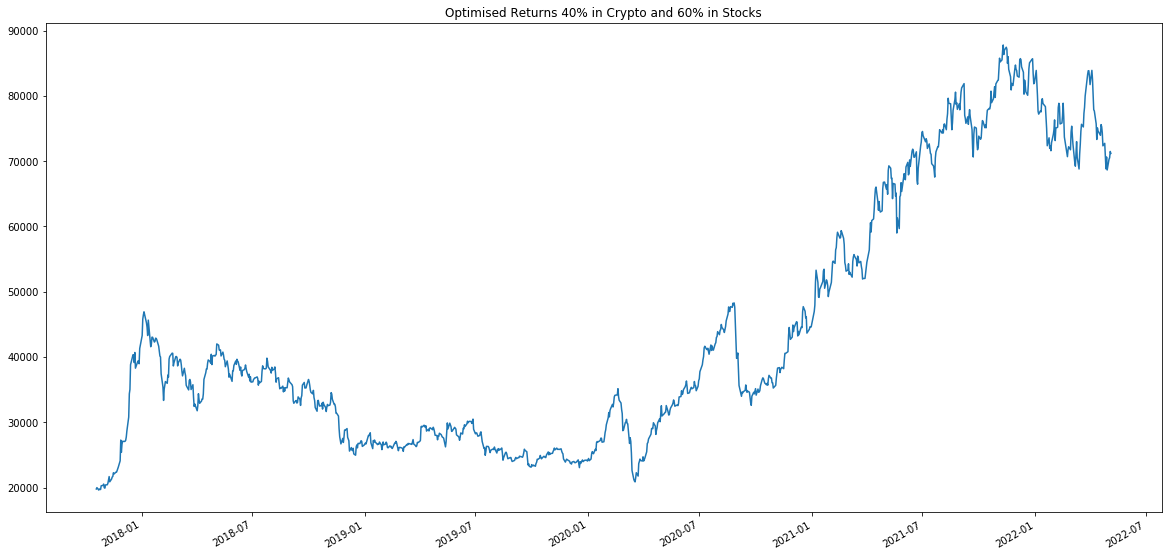

In [842]:
# Set initial investment
initial_investment = 20000

# Set weights
weights = [0.08, 0.08, 0.08, 0.08, 0.08, 0.12, 0.12, 0.12, 0.12, 0.12]

# Use the `dot` function to multiply weights by each stock's daily returns to output the unoptimized portfolio's daily returns
c40_s60_optimized_portfolio_returns = daily_returns.dot(weights)

# Use the `cumprod` function to calculate the unoptimized stock portfolio's cumulative returns
c40_s60_optimized_portfolio_returns = (1 + c40_s60_optimized_portfolio_returns).cumprod()

# Multiply the initial investment of `$20,000` against the portfolio's series of cumulative returns
c40_s60_optimized_portfolio_profits = (initial_investment * c40_s60_optimized_portfolio_returns)

# Plot the cumulatives return
c40_s60_optimized_portfolio_profits.plot(figsize=(20,10),
                                        title='Optimised Returns 40% in Crypto and 60% in Stocks')

### Scenario 5: Evaluate Investment in optimized Portfolio (60% in Crpto and 40% in Stocks)

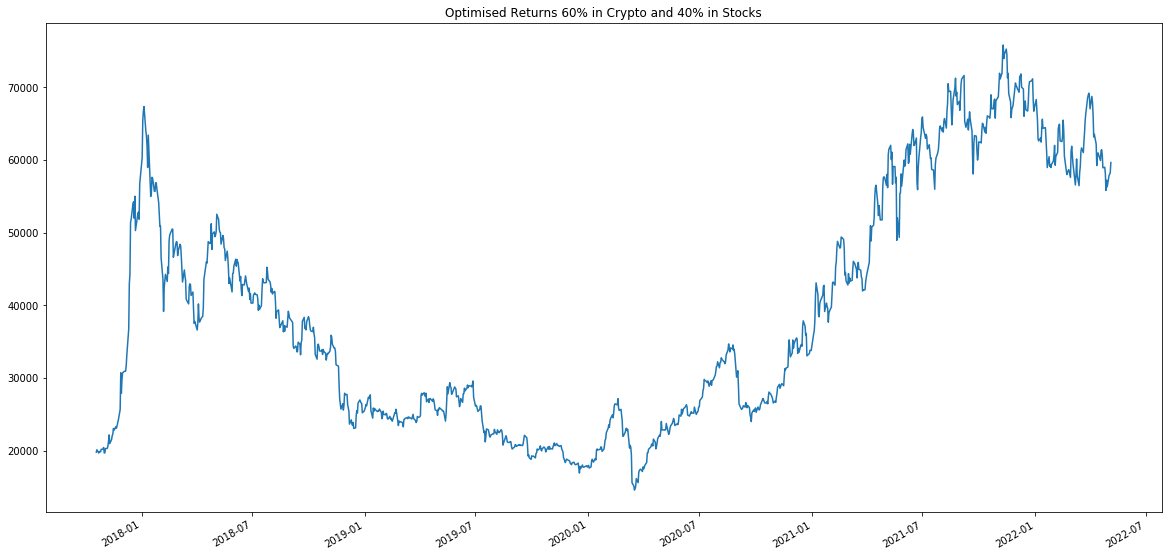

In [843]:
# Set initial investment
initial_investment = 20000

# Set weights
weights = [0.12, 0.12, 0.12, 0.12, 0.12, 0.08, 0.08, 0.08, 0.08, 0.08]

# Use the `dot` function to multiply weights by each stock's daily returns to output the unoptimized portfolio's daily returns
c60_s40_optimized_portfolio_returns = daily_returns.dot(weights)

# Use the `cumprod` function to calculate the unoptimized stock portfolio's cumulative returns
c60_s40_optimized_portfolio_returns = (1 + c60_s40_optimized_portfolio_returns).cumprod()

# Multiply the initial investment of `$20,000` against the portfolio's series of cumulative returns
c60_s40_optimized_portfolio_profits = (initial_investment * c60_s40_optimized_portfolio_returns)

# Plot the cumulatives return
c60_s40_optimized_portfolio_profits.plot(figsize=(20,10),
                                        title='Optimised Returns 60% in Crypto and 40% in Stocks')

### Scenario Overlay - Hypothetical Portfolio Investments Scenarios

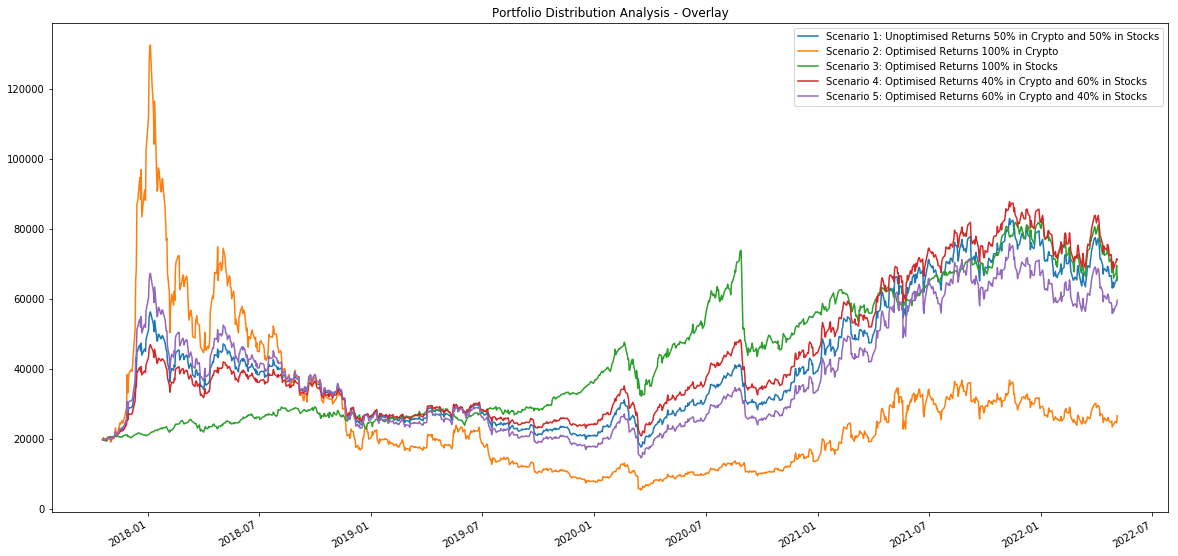

In [846]:
# Set the figure of the chart and plot each data trend on the single figure
ax = unoptimized_cumulative_profits.plot(figsize=(20,10),
                                        title='Portfolio Distribution Analysis - Overlay')
crypto_optimized_portfolio_profits.plot(ax=ax)
stock_optimized_portfolio_profits.plot(ax=ax)
c40_s60_optimized_portfolio_profits.plot(ax=ax)
c60_s40_optimized_portfolio_profits.plot(ax=ax)

ax.legend(['Scenario 1: Unoptimised Returns 50% in Crypto and 50% in Stocks', 
           'Scenario 2: Optimised Returns 100% in Crypto', 
           'Scenario 3: Optimised Returns 100% in Stocks', 
           'Scenario 4: Optimised Returns 40% in Crypto and 60% in Stocks', 
           'Scenario 5: Optimised Returns 60% in Crypto and 40% in Stocks'])

#### <font color='Red'> The top performing portfolio distribution is 40% Crypto and 60% Stocks</font>

## Performance Analysis
Calculate and Plot the daily returns.


In [775]:
ewm_30days = cumulative_returns.droplevel([-1], axis=1).ewm(halflife=30).mean().hvplot.line(
    title='Return after 5 years With 30 Days as Weighted Average',
    ylabel='Return x',
    xlabel='Year',
    width=1500,
    height=800
).opts(axiswise=True)

ewm_30days

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [776]:
combined_cummulative_returns_line = cumulative_returns.droplevel([-1], axis=1).hvplot.line(
    title='Return after 5 years',
    ylabel='Return x',
    xlabel='Year',
    width=1500,
    height=800
).opts(axiswise=True)

combined_cummulative_returns_line

:NdOverlay   [Variable]
   :Curve   [index]   (value)

## Crypto Performance
Performance graphs for the past 5 years of crypto

In [832]:
# Define a function that creates line graphs
def create_line_chart(investment, investment_type):
    investment=investment
    investment_type=investment_type
    data=combined_investments[investment_type][investment].hvplot.line(
        title=f'Performance of {investment} over the last 5 years',
        xlabel='Year',
        ylabel='Value in USD',
        yformatter='%.0f'
        ).opts(axiswise=True)
    return data

In [833]:
# BTC graph
btc_5 = create_line_chart(
    investment_type='Crypto Data',
    investment='BTC',
)
display(btc_5)

# ETH graph
eth_5 = create_line_chart(
    investment_type='Crypto Data',
    investment='ETH',
)
display(eth_5)

# LTC graph
ltc_5 = create_line_chart(
    investment_type='Crypto Data',
    investment='LTC',
)
display(ltc_5)

# XRP graph
xrp_5 = create_line_chart(
    investment_type='Crypto Data',
    investment='XRP',
)
display(xrp_5)

# ADA graph
ada_5 = create_line_chart(
    investment_type='Crypto Data',
    investment='ADA',
)
display(ada_5)

:Curve   [index]   (close)

:Curve   [index]   (close)

:Curve   [index]   (close)

:Curve   [index]   (close)

:Curve   [index]   (close)

## Stock Performance
Performance graphs for the past 5 years of stocks

In [834]:
# AAPL graph
aapl_5 = create_line_chart(
    investment_type='Stock Data',
    investment='AAPL',
)
display(aapl_5)

# MSFT graph
msft_5 = create_line_chart(
    investment_type='Stock Data',
    investment='MSFT',
)
display(msft_5)

# AMZN graph
amzn_5 = create_line_chart(
    investment_type='Stock Data',
    investment='AMZN',
)
display(amzn_5)

# TSLA graph
tsla_5 = create_line_chart(
    investment_type='Stock Data',
    investment='TSLA',
)
display(tsla_5)

# GOOGL graph
googl_5 = create_line_chart(
    investment_type='Stock Data',
    investment='GOOGL',
)
display(googl_5)

:Curve   [index]   (close)

:Curve   [index]   (close)

:Curve   [index]   (close)

:Curve   [index]   (close)

:Curve   [index]   (close)

In [804]:
#Run the Covid plot
covid_cumulative_returns_plot = cumulative_returns.loc["2020-01-01" : "2020-04-05"].droplevel(axis=1, level=[-1]).hvplot.line(title='Volatitlity to Blackswan Event (Covid-19)',
                                                                                                                             xlabel='Dates',
                                                                                                                              ylabel='Return (x)',
                                                                                                                              width=1500,
                                                                                                                              height=800
                                                                                                                             ).opts(axiswise=True)
covid_cumulative_returns_plot

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [792]:
# #Run the War  plot for zoomed in graph
market_uncertaintity_plot = cumulative_returns.droplevel(axis=1, level=[-1]).loc["2021-11-10" : "2022-05-05"].hvplot.line(title='Volatility to Market Uncertaintity',
                                                                                                                         ylabel='Return x',
                                                                                                                         xlabel='Date',
                                                                                                                         width=1500,
                                                                                                                         height=800
                                                                                                                         ).opts(axiswise=True)
market_uncertaintity_plot

:NdOverlay   [Variable]
   :Curve   [index]   (value)

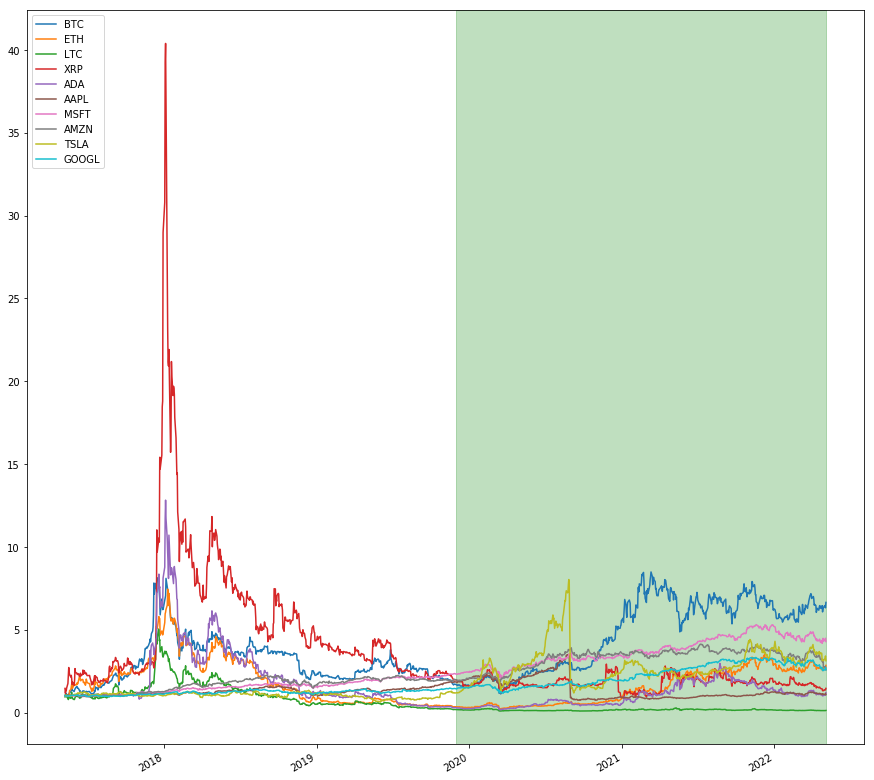

In [782]:
#Run the Covid plot
cumulative_returns.droplevel(axis=1, level=[-1]).plot(
    kind='line',
    figsize=(15,15)
)

#Highlight start to end date of interest
plt.axvspan("2019-12-01", "2022-05-05", color='green', alpha=0.25)

Text(2021-11-26, 8.1, 'Covid Omicron strain')

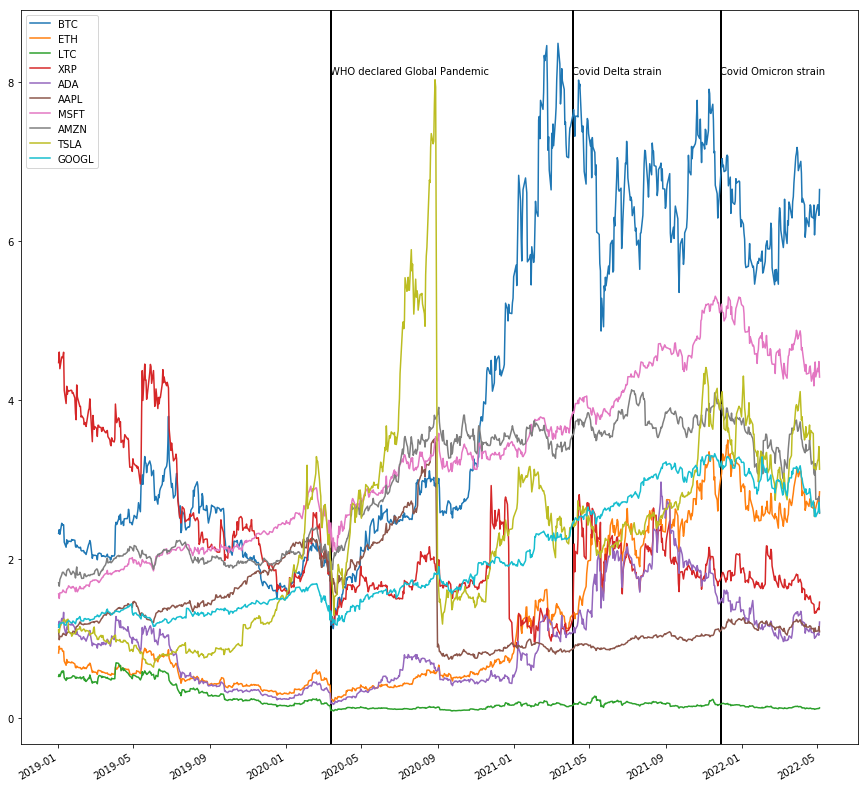

In [523]:
#Run the Covid plot for zoomed in graph
covid_cumulative_returns_plot_2 = covid_cumulative_returns.loc["2019-01-01"  : "2022-05-05"].droplevel(axis=1, level=[-1]).plot(
    kind='line',
    figsize=(15,15)
);

#Highlight imporatnt dates of Covid
plt.axvspan("2020-03-11", "2020-03-13", color='black', alpha=1);
plt.axvspan("2021-04-04", "2021-04-05", color='black', alpha=1);
plt.axvspan("2021-11-26", "2021-11-28", color='black', alpha=1);

#Add text label
covid_cumulative_returns_plot.text(
"2020-03-11", 8.1, "WHO declared Global Pandemic")
covid_cumulative_returns_plot.text(
"2021-04-04", 8.1, "Covid Delta strain")
covid_cumulative_returns_plot.text(
"2021-11-26", 8.1, "Covid Omicron strain")

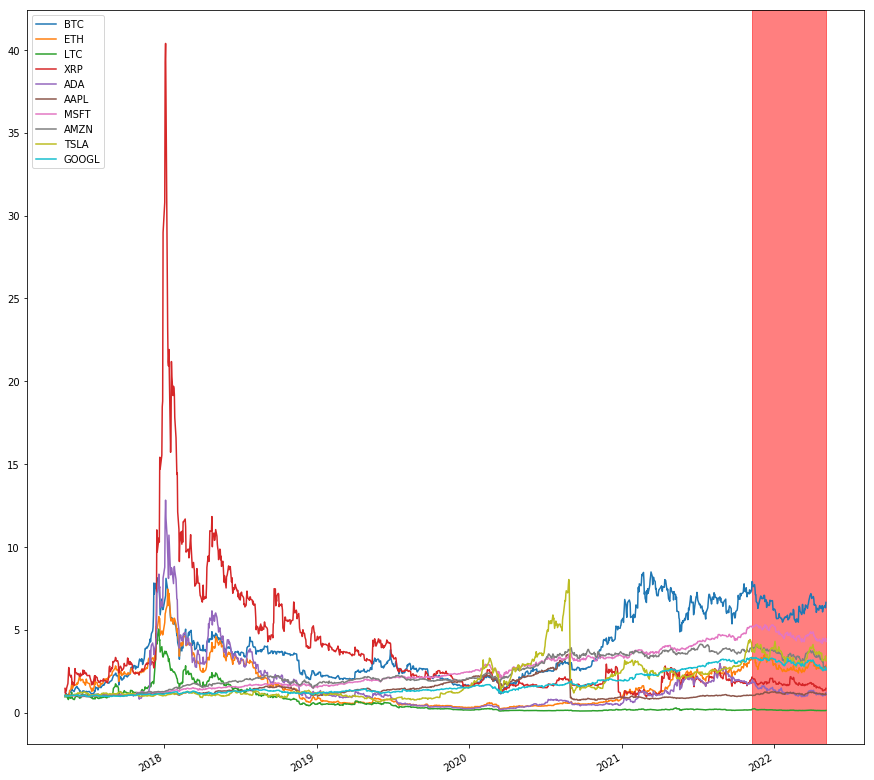

In [525]:
#Run the War plot
war_cumulative_returns.droplevel(axis=1, level=[-1]).plot(
    kind='line',
    figsize=(15,15)
)
#Highlight start to end date of interest
plt.axvspan("2021-11-10", "2022-05-05", color='red', alpha=0.5)

Text(2022-02-24, 14, 'Russia launched invasion of Ukraine')

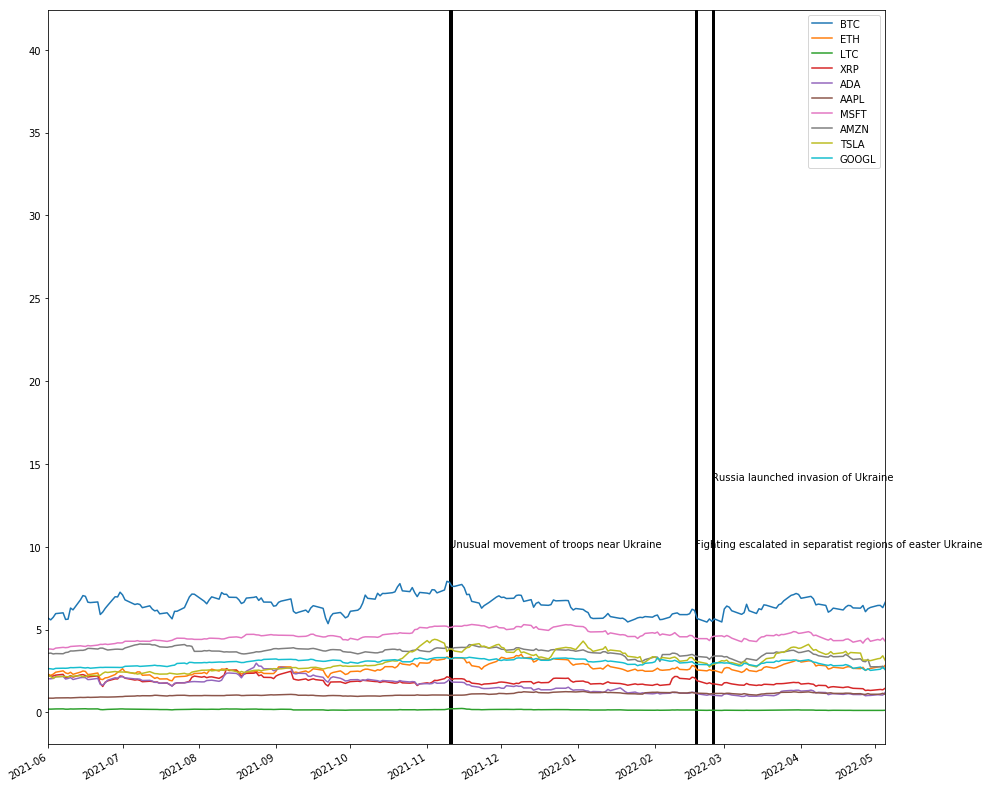

In [754]:
#Run the War  plot for zoomed in graph
market_uncertaintity_plot_2 = cumulative_returns.droplevel(axis=1, level=[-1]).plot(
    kind='line',
    figsize=(15,15)
)

#Zoom in
market_uncertaintity_plot_2.set_xlim("2021-06-01", "2022-05-05")
#Highlight imporatnt dates of Covid
plt.axvspan("2021-11-10", "2021-11-11", color='black', alpha=1)
plt.axvspan("2022-02-17", "2022-02-18", color='black', alpha=1)
plt.axvspan("2022-02-24", "2022-02-25", color='black', alpha=1)
#Add text label
market_uncertaintity_plot_2.text(
"2021-11-10", 10, "Unusual movement of troops near Ukraine")
market_uncertaintity_plot_2.text(
"2022-02-17", 10, "Fighting escalated in separatist regions of easter Ukraine")
market_uncertaintity_plot_2.text(
"2022-02-24", 14, "Russia launched invasion of Ukraine")

## Dashboard

In [835]:
# Create a Title for the Dashboard
dash_title = '# Investment Dashboard'

# Define a welcome text
welcome_message = '''
There's one golden investment rule that you should always keep in mind: Never invest money that you can't afford to lose. Market can be rewarding, but it do tests you.  Always Do Your Own Research - DYOR"
'''

# Create panels to structure the layout of the dashboard
# Dwelling ypes Panel
returns_anlysis = pn.Column(
    "## Analysis on Returns Over 5 Years",
    pn.Row(value_after_5_years_bar),
    pn.Row(stock_value_after_5_years_bar, crypto_value_after_5_years_bar)
)

performance_analysis = pn.Column(
    '## Performance of Crypto vs. Stock',
    pn.Row(btc_5, aapl_5),
    pn.Row(eth_5, msft_5),
    pn.Row(ltc_5, amzn_5),
    pn.Row(xrp_5, tsla_5),
    pn.Row(ada_5, googl_5)
    )

ewm_rolling = pn.Column(
    ewm_30days, rolling_window_plot)

volatility = pn.Column(covid_cumulative_returns_plot, market_uncertaintity_plot)

dashboard = pn.Tabs(
    ('Welcome', welcome_message),
    ('Performance Analysis', performance_analysis),
    ('Returns', returns_anlysis),
    ('Volatility', volatility),
    ('Risk Analysis', risk_analysis),
    ('Cumulative Return', ewm_rolling),
)

In [836]:
dashboard.servable()

Tabs
    [0] Markdown(str, name='Welcome')
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(Curve)
            [1] HoloViews(Curve)
        [2] Row
            [0] HoloViews(Curve)
            [1] HoloViews(Curve)
        [3] Row
            [0] HoloViews(Curve)
            [1] HoloViews(Curve)
        [4] Row
            [0] HoloViews(Curve)
            [1] HoloViews(Curve)
        [5] Row
            [0] HoloViews(Curve)
            [1] HoloViews(Curve)
    [2] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(Bars)
        [2] Row
            [0] HoloViews(Bars)
            [1] HoloViews(Bars)
    [3] Column
        [0] HoloViews(NdOverlay)
        [1] HoloViews(NdOverlay)
    [4] Column
        [0] Row
            [0] Str(AxesSubplot)
            [1] Str(AxesSubplot)
    [5] Column
        [0] HoloViews(NdOverlay)
        [1] HoloViews(NdOverlay)